# 1 . Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt 
import numpy as np

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [3]:
# Hyperparameters

num_epochs = 5
batch_size = 4
learning_rate  = 0.001

In [4]:
# dataset has PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [5]:
# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10("./data",train=True,download=True,transform=transform)

test_dataset = torchvision.datasets.CIFAR10("./data",train=False,download=True,transform=transform)


train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

0it [00:00, ?it/s]Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz
100%|█████████▉| 170401792/170498071 [21:03<00:00, 228507.98it/s]Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
170500096it [21:20, 228507.98it/s]

In [26]:

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [6]:
for data in train_loader:
    print(data)
    break

[tensor([[[[-0.6863, -0.4118, -0.3333,  ..., -0.1922, -0.1451, -0.2706],
          [-0.6471, -0.5216, -0.4275,  ..., -0.0431, -0.1608, -0.0196],
          [-0.6392, -0.5451, -0.4275,  ...,  0.1059,  0.0431,  0.2549],
          ...,
          [-0.2549, -0.1843, -0.1922,  ..., -0.2706, -0.2392, -0.2235],
          [-0.2627, -0.1686, -0.2000,  ..., -0.2549, -0.2627, -0.2627],
          [-0.3098, -0.2627, -0.2627,  ..., -0.2471, -0.2471, -0.2627]],

         [[-0.8196, -0.4510, -0.2471,  ..., -0.3412, -0.3176, -0.3882],
          [-0.7961, -0.5686, -0.3961,  ..., -0.1608, -0.2941, -0.1137],
          [-0.7804, -0.5843, -0.3882,  ..., -0.0118, -0.0667,  0.1529],
          ...,
          [-0.2784, -0.2000, -0.2157,  ..., -0.3098, -0.2784, -0.2549],
          [-0.2784, -0.1843, -0.2157,  ..., -0.2941, -0.3020, -0.3098],
          [-0.3176, -0.2706, -0.2784,  ..., -0.2784, -0.2863, -0.3020]],

         [[-0.8824, -0.4196, -0.2000,  ..., -0.6157, -0.6078, -0.6157],
          [-0.8745, -0.5843, 

In [10]:
# Sample Image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [13]:
# get some random training images

dataiter = iter(train_loader)
images,labels = dataiter.next()

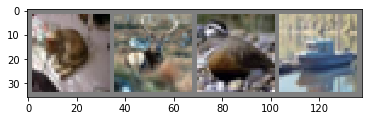

In [14]:
# show images

imshow(torchvision.utils.make_grid(images))

In [17]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
#set1
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=6,kernel_size=5)
        self.pool = nn.MaxPool2d(2,2)
#set2
        self.conv2 = nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5)
        self.fc1 = nn.Linear(16*5*5,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)


    def forward(self,x):
        # -> n,3,32,32
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1,16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x # No softmax as crossEntropy has one


model = ConvNet().to(device) # if using gpu
print(model)

ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [21]:
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images,labels) in enumerate(train_loader):

        # origin shape: [4, 3, 32, 32] = 4, 3, 1024 ->(batch_size,channels,img_size,img_size)
        # input_layer: 3 input channels, 6 output channels, 5 kernel size

        images = images.to(device)
        labels = labels.to(device)

        # Forward Pass
        outputs = model(images)
        loss = criterion(outputs,labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print('Finished Training')

Epoch [1/5], Step [2000/12500], Loss: 1.1497
Epoch [1/5], Step [4000/12500], Loss: 1.4243
Epoch [1/5], Step [6000/12500], Loss: 1.3427
Epoch [1/5], Step [8000/12500], Loss: 1.2225
Epoch [1/5], Step [10000/12500], Loss: 1.4000
Epoch [1/5], Step [12000/12500], Loss: 0.5078
Epoch [2/5], Step [2000/12500], Loss: 2.1130
Epoch [2/5], Step [4000/12500], Loss: 0.6021
Epoch [2/5], Step [6000/12500], Loss: 0.4898
Epoch [2/5], Step [8000/12500], Loss: 1.6913
Epoch [2/5], Step [10000/12500], Loss: 1.0556
Epoch [2/5], Step [12000/12500], Loss: 1.2145
Epoch [3/5], Step [2000/12500], Loss: 0.8064
Epoch [3/5], Step [4000/12500], Loss: 1.3824
Epoch [3/5], Step [6000/12500], Loss: 1.7624
Epoch [3/5], Step [8000/12500], Loss: 1.2382
Epoch [3/5], Step [10000/12500], Loss: 0.5640
Epoch [3/5], Step [12000/12500], Loss: 0.9338
Epoch [4/5], Step [2000/12500], Loss: 1.0761
Epoch [4/5], Step [4000/12500], Loss: 1.3793
Epoch [4/5], Step [6000/12500], Loss: 1.0592
Epoch [4/5], Step [8000/12500], Loss: 1.3171
Epoc

In [23]:
PATH = './cnn.pth'
torch.save(model.state_dict(),PATH)

In [27]:
with torch.no_grad():
    no_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples =[0 for i in range(10)]

    for images,labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _,predicted = torch.max(outputs,1)
        n_samples += labels.size(0)
        no_correct += (predicted == labels).sum().item()

        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if(label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1


    acc = 100 * no_correct / n_samples
    print(f"Accuracy of the network:{acc}%")

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')



Accuracy of the network:58.46%
Accuracy of plane: 70.9 %
Accuracy of car: 76.5 %
Accuracy of bird: 44.7 %
Accuracy of cat: 28.1 %
Accuracy of deer: 39.0 %
Accuracy of dog: 70.7 %
Accuracy of frog: 66.4 %
Accuracy of horse: 53.9 %
Accuracy of ship: 68.1 %
Accuracy of truck: 66.3 %
